# Analysis Functions

In [10]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit


No pytransport functionality
No pytransport functionality


In [11]:
def ls(path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

In [12]:
def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        with open(path + folder + '/input_cache/config_sim.yaml', 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
            obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])

In [13]:
def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    with open(path + folder + '/input_cache/config_sim.yaml', 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)


In [14]:
def plot_at_turn(TCCS, TARGET, n_turn):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]


    print("IMPACT ON TCCS AT TURN ", n_turn)    
    TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True)
    print("IMPACT ON TARGET AT TURN ", n_turn)    
    TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'])

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]
   
    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True)

In [15]:
def plot_turn_impacts(impact_list, turns=200, threshold=10000):
    if not hasattr(impact_list, '__iter__') or isinstance(h5_file_path, str):
            impact_list = [impact_list]
    dfs = [i.impact_part for i in impact_list]

    x = np.arange(turns)
    fig, ax = plt.subplots(figsize=(7, 5))

    for i, df in enumerate(dfs):
        imp = []
        for t in range(turns):
            imp.append(len(df[df['this_turn']==t]))
        ax.plot(x, imp, label=f'impacts {i}')
        peaks = []
        for i in range(1, len(imp)):
            if imp[i] - imp[i-1] > threshold:
                peaks.append(i)
        print('Peaks at turns: ', peaks)
                
             
        print(np.argmax(imp))
    #ax.set_yscale('log')
    ax.legend()

def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

In [43]:
class ParticleAnalysis():

    def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V', jaw_L = None ):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2

        self.impact_part = None
        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.coll_names = {'TCCS': 'tccs.5r3.b2', 'TCCP': 'tccp.4l3.b2', 'TARGET': 'target.4l3.b2', 'TCLA': 'tcla.a5l3.b2'}
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        return path_list   
    
    

    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       part_per_job = 100000):
                
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name)
            self.n_jobs = len(h5_file_path)
        else:
            h5_file_path = (subprocess.check_output("echo " + default_path + path +file_name, shell=True)).decode('ascii').strip()

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0])
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + part_per_job*job_id
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
                       
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c

        hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        self.impact_part = self.data[hit_mask]
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, linewidth=1, edgecolor='r', facecolor='none', zorder=100)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, axins_params = ["100%", "5%", "right", -6], **kwargs):

        h = ax.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm(), zorder=2)#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_yticks()])
        ax_tw = ax.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax_tw.set_ylim(ax.get_ylim()[0]/sigma_abs, ax.get_ylim()[1]/sigma_abs)
        
        if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
        ax_tw.set_yticks(yticks)
        ax_tw.set_ylabel(r' n $\sigma$')
        
        ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')


            


    #HOME
    def plot_py_distribution(self, fig, ax, py, fit = None, **kwargs):

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            py = py[(py >= py_min) & (py <= py_max)]

        ax.hist(py, bins=100) 
        ax.set_xlabel(r'py [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, **kwargs):
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
        ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
        ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        self.plot_xy_distribution(fig1, ax3, x, y)
        self.plot_rectangle(ax3, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")        
        ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])


        ax22 = fig1.add_subplot(2,3,5)
        self.plot_py_distribution(fig1, ax22, py, **kwargs)


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm(), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss



    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit

        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = True ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)

    def plot_phasespace(self, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(self.data['x'], self.data['px'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(self.data['y'], self.data['py'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')
        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.coll_names['TCLA']: 1.0, self.coll_names['TCCS']: 0.004, self.coll_names['TCCP']: 0.07, self.coll_names['TARGET']: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')







# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                xp_version = 'book'
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    
    self.align_angle = align_angle
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.xp_version = xp_version


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)

    
    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")
    

  def plot_py_distribution(self, fig, ax, py, print=True, **kwargs):
        
        super().plot_py_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print:
                        ax.set_title(f'N particle inside critical angle range: {chann}')






  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part), f'\t{chann_num/len(self.impact_part)*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    data = self.data[['py', 'at_element']]
    min_py = data['py'].min()
    max_py = 0 # data['py'].max()
    
    n_steps = 1000
    x = np.linspace(min_py + self.xp_crit, max_py - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data['py'] > x[i] - self.xp_crit) & (data['py'] < x[i] + self.xp_crit)
        y.append(len(data['py'][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_py_distribution(fig1, ax2, data['py'], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data['py'] > self.align_angle  - np.abs(self.xp_crit)) & (data['py'] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data['py'][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        self.impact_part = self.data[hit_mask]




# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V', jaw_L = None):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids: {data[duplicated_mask]}')

    


  def optimize_POT(self, set = False, mode='fit', plot = True):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')




      

# Injection

In [8]:
inj_nom_abs = 'TEST_RUN3_TCLA_CRY5.0___20240408-1639'
#inj_closed_abs = 'TEST_RUN3_TCLA9.5_CRY5.0___20240409-1002'
inj_closed_abs = 'TEST_RUN3_TCLA9.5_CRY5.0_v2___20240409-1013'

In [11]:
TCCS_inj = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-4.5610715330570635e-05, sigma=0.0013131931107254957)
TCLA_inj = TargetAnalysis(n_sigma=9.5, length=1, ydim=0.025, xdim=0.025, sigma=0.001139267854748564)

In [12]:
TCCS_inj.load_particles(inj_closed_abs, df_key = 'TCCS_impacts')

In [13]:
TCLA_inj.load_particles(inj_closed_abs, df_key = 'TCLA_impacts')

There are repeated particle ids: 15887    1140673
31875    2065241
40163    5975953
Name: particle_id, dtype: int32


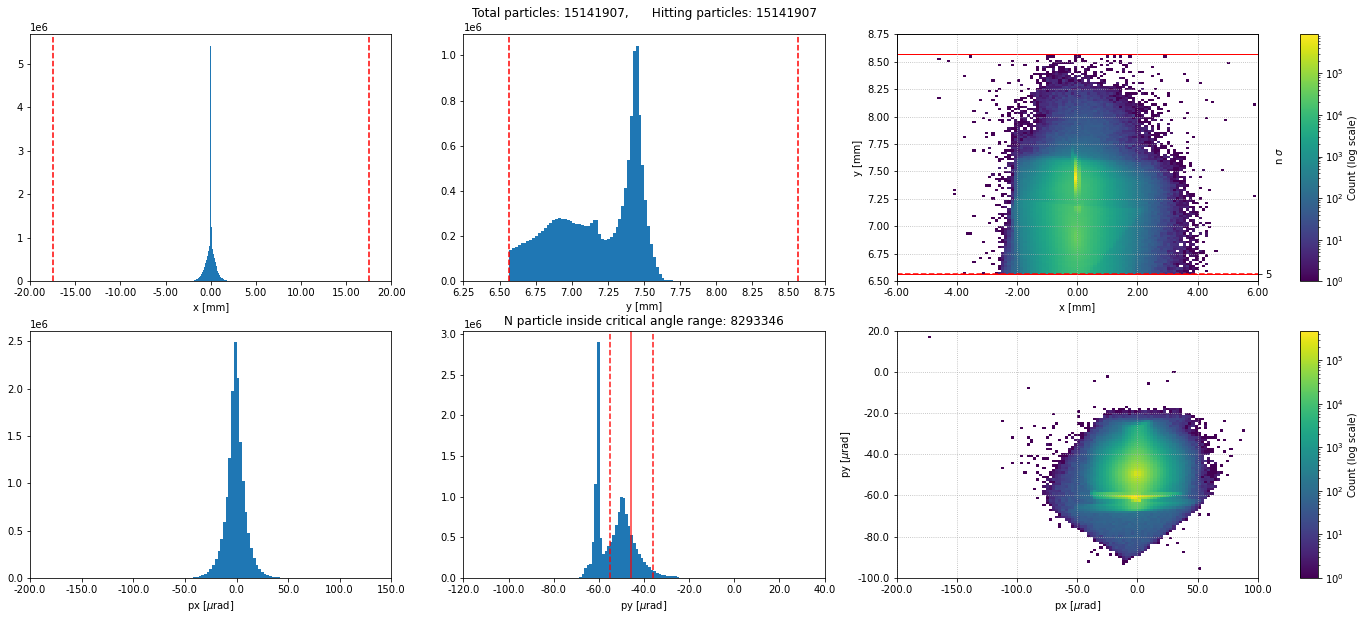

In [14]:
TCCS_inj.align_TCCS()
TCCS_inj.compute_impact_particles(xpcrit=True)

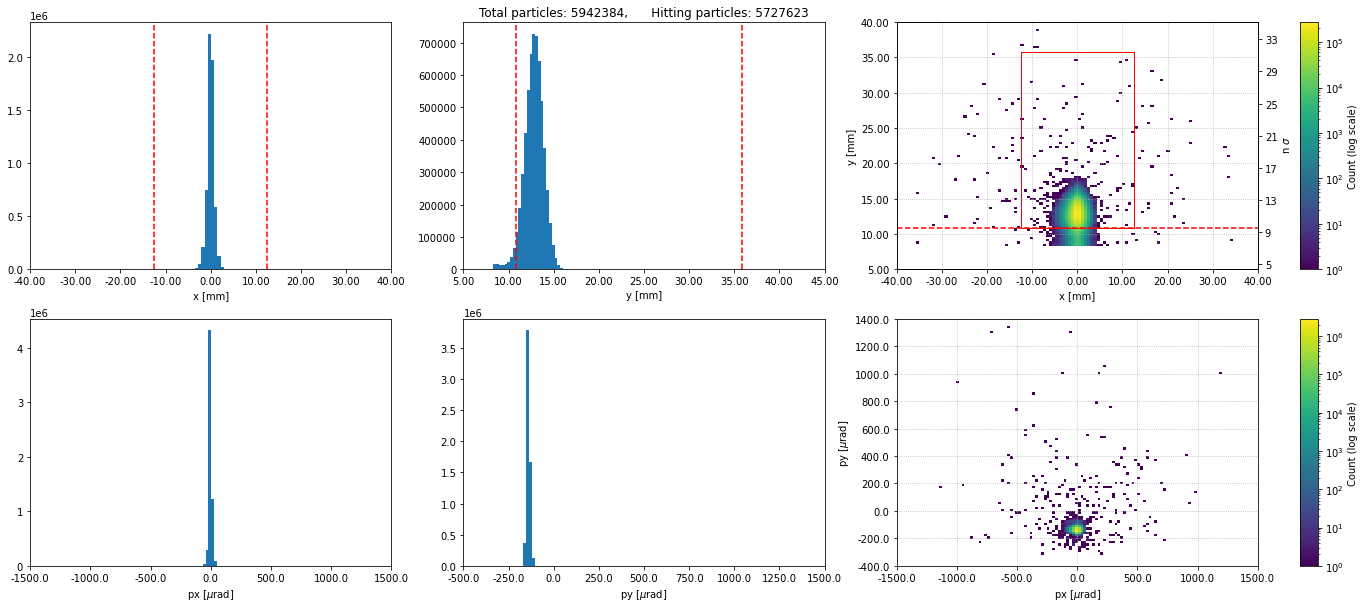

In [15]:
TCLA_inj.compute_impact_particles()

In [16]:
TCCS_inj.compute_channeled_part(TCLA_inj.impact_part)

n particles that hit TCCP inside critical angle range: 	 5726130
n part inside critical angle range: 			 8293346 		69.04%
n part that hit TCCS (multiple):			 15141907 	37.82%
n part that hit TCCP: 					 5727623 		99.97%
total n particle in simulation: 			 1.0e+07	57.26%


# 1 TeV

In [17]:
Tev1 = 'TEST_RUN3_TCLA_CRY5.0_1TeV___20240410-1733'

In [18]:
TCCS_Tev1 = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-3.0554011408702175e-05, sigma=0.0008797100205298778)
TCLA_Tev1 = TargetAnalysis(n_sigma=12.7, length=1, ydim=0.025, xdim=0.025, sigma=0.0007631420193989737)

In [19]:
TCCS_Tev1.load_particles(Tev1, df_key = 'TCCS_impacts')
TCLA_Tev1.load_particles(Tev1, df_key = 'TCLA_impacts')

There are repeated particle ids: 43627     175059
30044     658861
48611     780922
17567    1038865
33640    1063332
42381    1073903
12572    1127937
43288    1175106
38804    1369315
40008    1771030
19149    2042061
21735    2347820
59182    2993950
4261     3009317
2540     3405611
56973    3791330
27400    3855743
46273    4478512
35998    4565799
14313    4931469
62324    5397721
47972    5480255
43604    5575213
58913    5693850
44004    5775477
7312     5816265
20048    5843970
58456    6592926
62312    6597585
17247    6738297
24592    7151958
20825    7246018
4815     7310761
37841    7468545
59495    7494520
43188    7674910
4952     7710830
28291    8256623
3638     8307895
28544    8457197
63251    8499000
26322    8854451
1723     8903717
1484     9003301
27466    9055713
60948    9195913
43032    9874601
Name: particle_id, dtype: int32


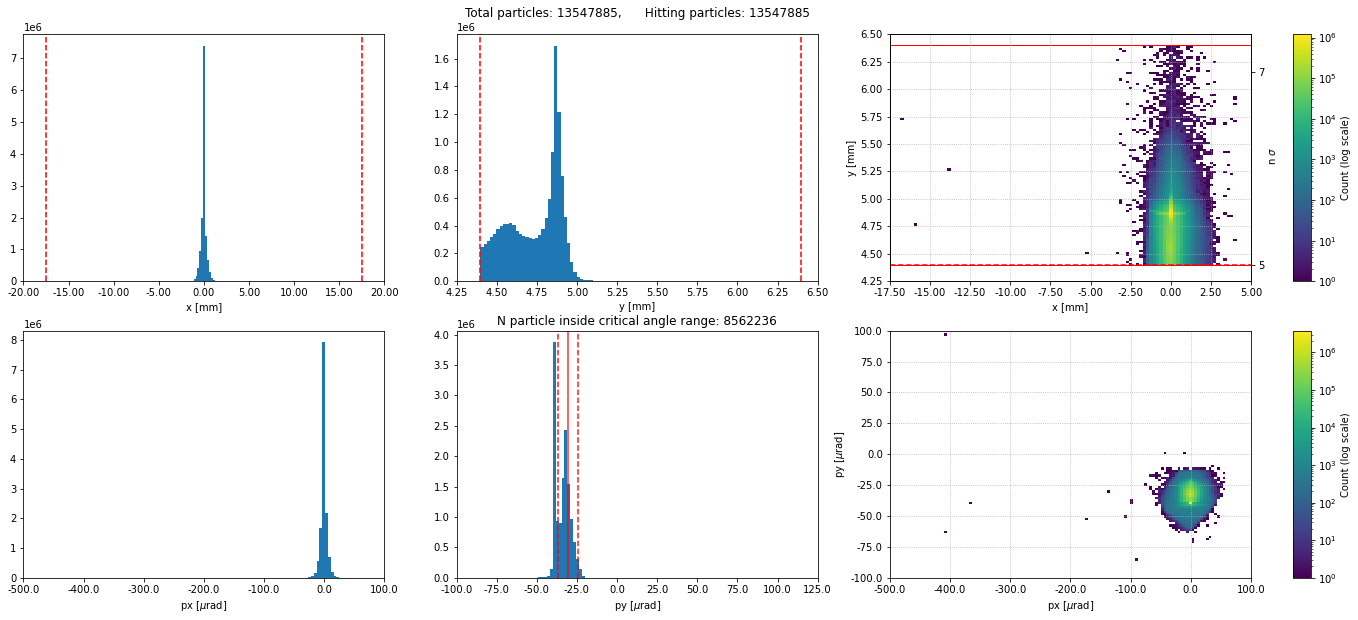

In [20]:
TCCS_Tev1.align_TCCS()
TCCS_Tev1.compute_impact_particles(xpcrit=True)

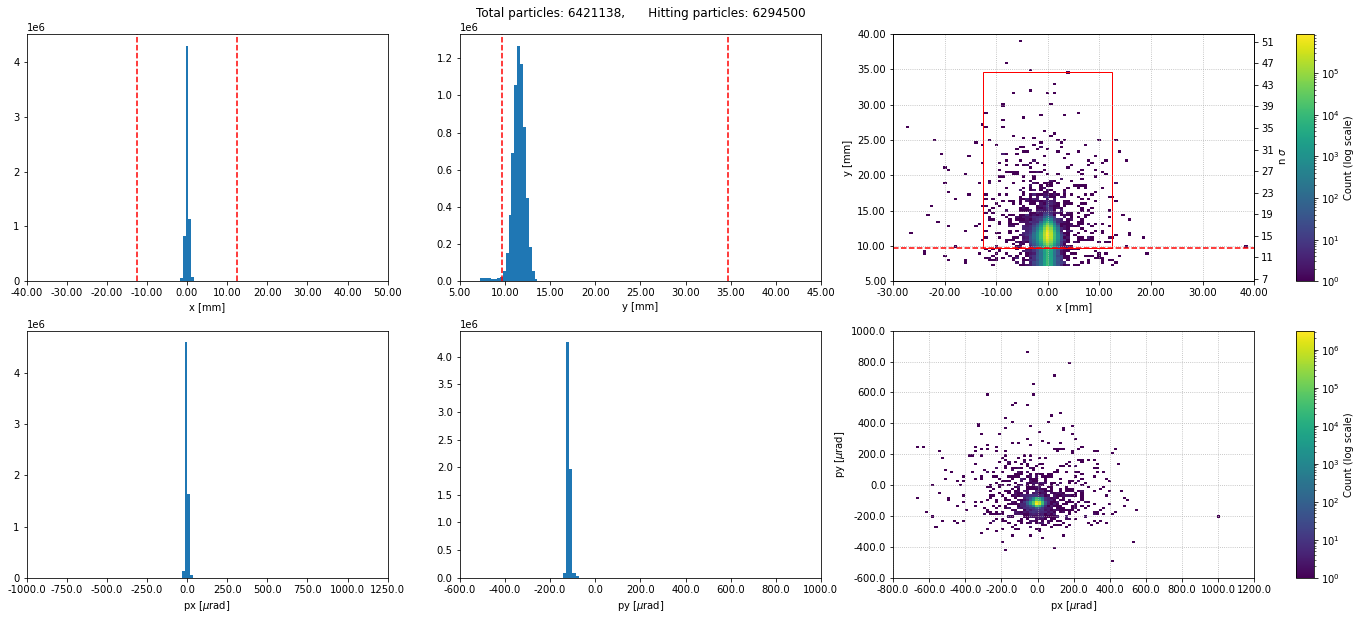

In [21]:
TCLA_Tev1.compute_impact_particles()

In [22]:
TCCS_Tev1.compute_channeled_part(TCLA_Tev1.impact_part)

n particles that hit TCCP inside critical angle range: 	 6293515
n part inside critical angle range: 			 8562236 		73.50%
n part that hit TCCS (multiple):			 13547885 	46.45%
n part that hit TCCP: 					 6294500 		99.98%
total n particle in simulation: 			 1.0e+07	62.94%


# 3 TeV

In [23]:
Tev3 = 'TEST_RUN3_TCLA_CRY5.0_3TeV___20240410-1733'

In [24]:
TCCS_Tev3 = CrystalAnalysis(n_sigma=4.999999999999999, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.7970726858118953e-05, sigma=0.0005170095666187551)
TCLA_Tev3 = TargetAnalysis(n_sigma=15.1, length=1, ydim=0.025, xdim=0.025, sigma=0.0004479828523154816)

In [25]:
TCCS_Tev3.load_particles(Tev3, df_key = 'TCCS_impacts')
TCLA_Tev3.load_particles(Tev3, df_key = 'TCLA_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_TCLA_CRY5.0_3TeV___20240410-1733
!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_TCLA_CRY5.0_3TeV___20240410-1733
There are repeated particle ids: 52006     676104
24330     740798
8703     2114690
35395    2356502
2581     2904354
45084    3067998
54689    3379008
59099    4084413
23716    4140205
43537    5065803
66609    5292913
2558     5404218
71111    5998293
239      6000408
18586    6631509
45309    7268484
32423    7453222
10531    8317712
72569    8399708
12611    8721362
49904    9373466
Name: particle_id, dtype: int32


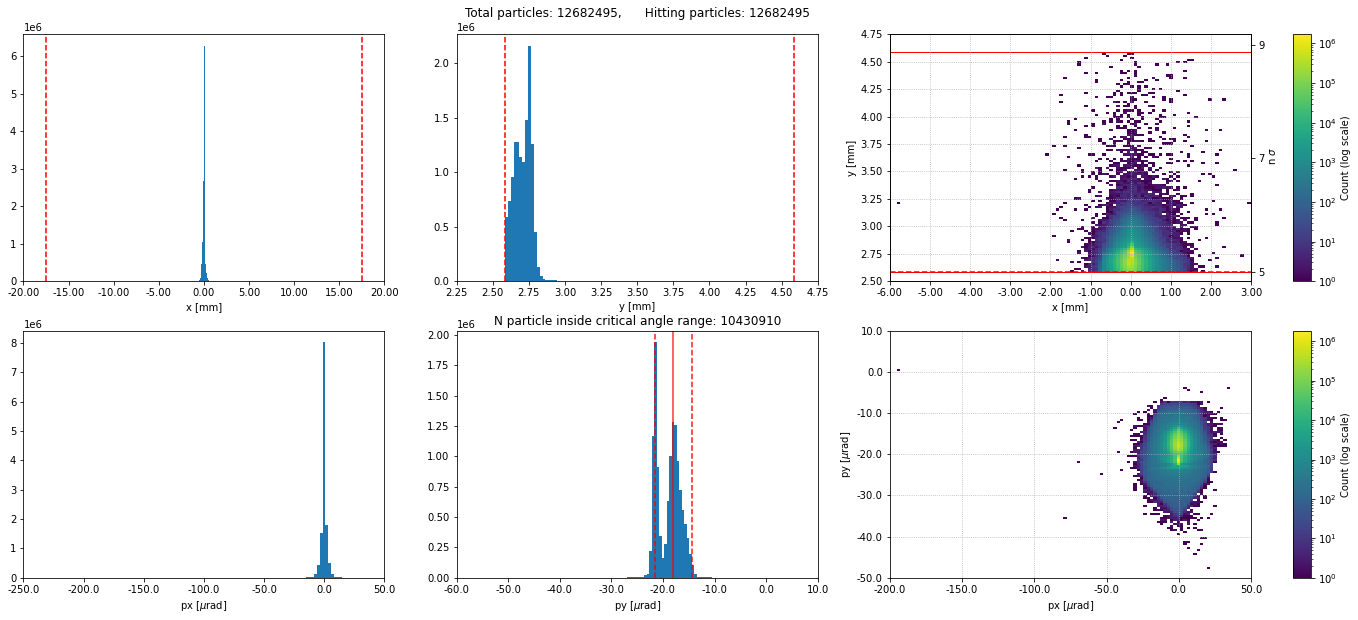

In [26]:
TCCS_Tev3.align_TCCS()
TCCS_Tev3.compute_impact_particles(xpcrit=True)

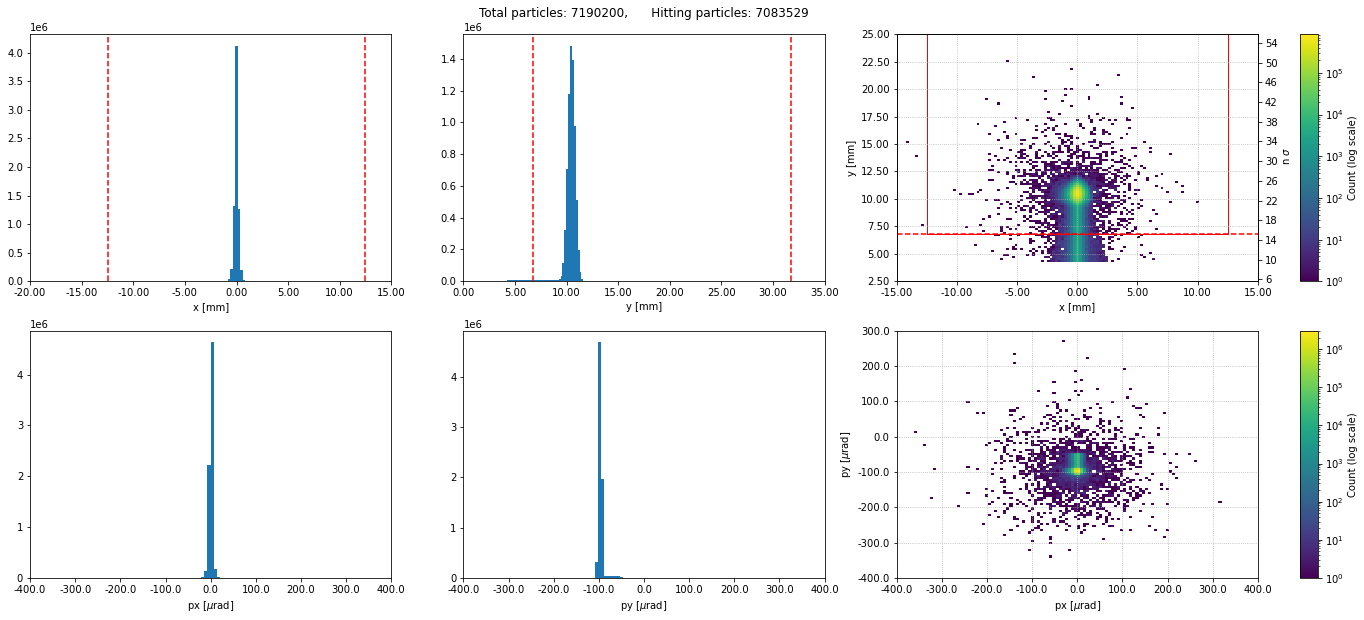

In [27]:
TCLA_Tev3.compute_impact_particles()

In [28]:
TCCS_Tev3.compute_channeled_part(TCLA_Tev3.impact_part)

n particles that hit TCCP inside critical angle range: 	 7083175
n part inside critical angle range: 			 10430910 		67.91%
n part that hit TCCS (multiple):			 12682495 	55.85%
n part that hit TCCP: 					 7083529 		100.00%
total n particle in simulation: 			 9.9e+06	71.55%


# Flat Top

In [29]:
ft = 'TEST_RUN3_TCLA_CRY5.0_flat_top___20240409-1547'

In [35]:
TCCS_ft = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.1764531649145031e-05, sigma=0.00033827189357608494)
TCLA_ft = TargetAnalysis(n_sigma=20.0, length=1, ydim=0.025, xdim=0.025, sigma=0.00029257754172899817)

In [36]:
TCCS_ft.load_particles(ft, df_key = 'TCCS_impacts')
TCLA_ft.load_particles(ft, df_key = 'TCLA_impacts')

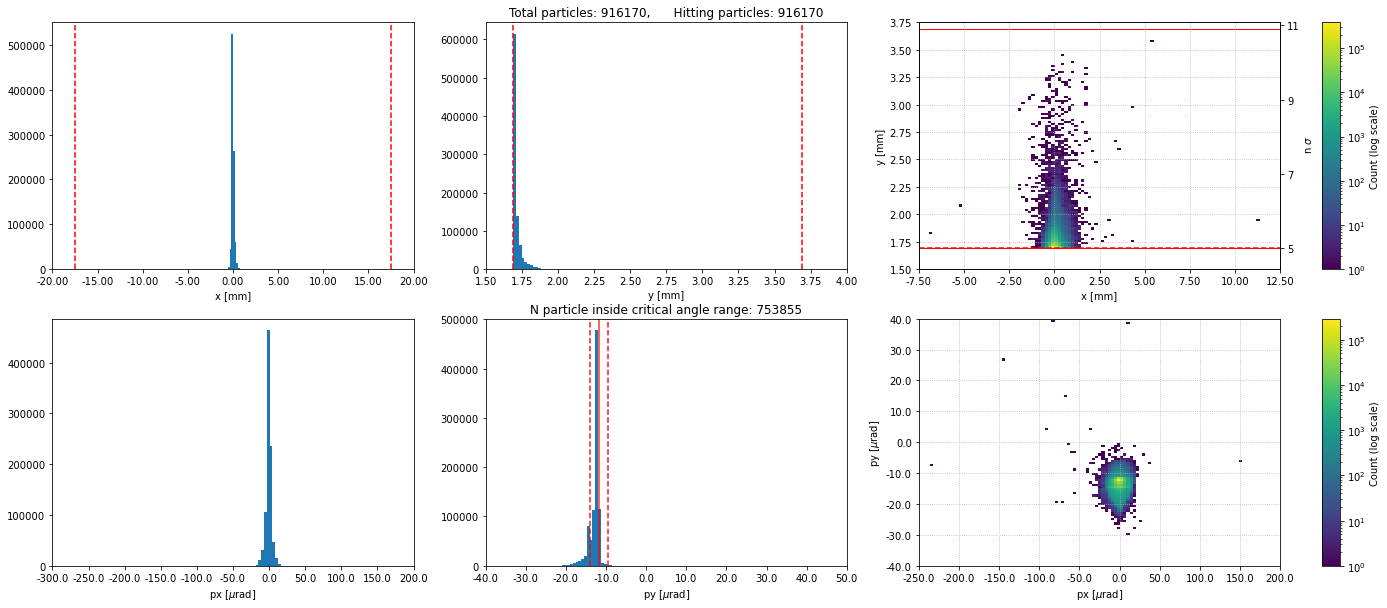

In [37]:
TCCS_ft.align_TCCS()
TCCS_ft.compute_impact_particles(xpcrit=True)

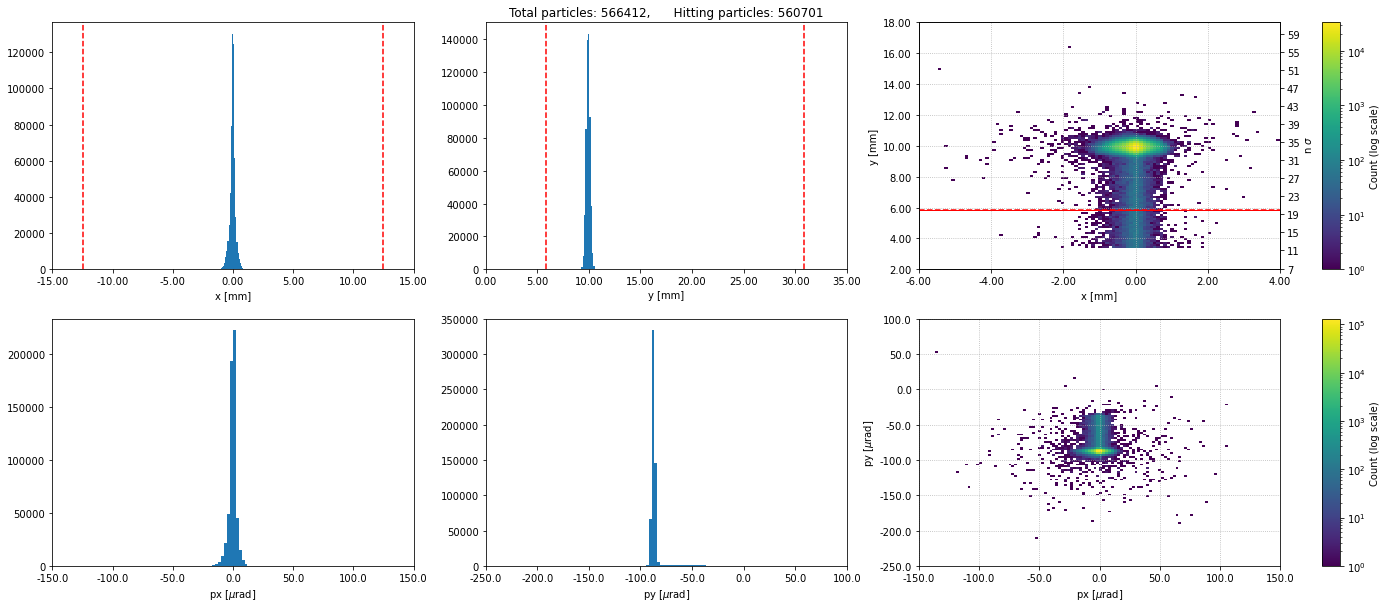

In [38]:
TCLA_ft.compute_impact_particles()

In [39]:
TCCS_ft.compute_channeled_part(TCLA_r3_ft.impact_part)

n particles that hit TCCP inside critical angle range: 	 560682
n part inside critical angle range: 			 753855 		74.38%
n part that hit TCCS (multiple):			 916170 	61.20%
n part that hit TCCP: 					 560701 		100.00%
total n particle in simulation: 			 1.0e+07	5.61%


# BLM 

In [44]:
blm3 ='TEST_RUN3_BLMs_3TeV___20240415-0911'
blm1 ='TEST_RUN3_BLMs_1TeV___20240416-0934'
blm_inj = 'TEST_RUN3_BLMs_inj___20240416-0937'

In [45]:
TCCP_blm3 = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008, bending_radius=10.0, align_angle=3.0505794140362174e-05, sigma=0.0005655621010575329)
BLM_blm3 = TargetAnalysis(n_sigma=50.82718557875304, length=0, ydim=0.025, xdim=0.025, sigma=0.0005902353171516289, jaw_L=0.03)

In [46]:
TCCP_blm1 = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502339166e-05, sigma=0.0009633910371377494, jaw_L=0.004816507499281447)
BLM_blm1 = TargetAnalysis(n_sigma=29.8380490665404, length=0, ydim=0.025, xdim=0.025, sigma=0.0010054276649622245, jaw_L=0.03)

In [47]:
TCCP_blm_inj = CrystalAnalysis(n_sigma=4.999999999999999, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=7.759101388694563e-05, sigma=0.0014381745341118704, jaw_L=0.007191216461231016)
BLM_blm_inj = TargetAnalysis(n_sigma=19.987601927403542, length=0, ydim=0.025, xdim=0.025, sigma=0.0015009304322230466, jaw_L=0.03)

## Injection

In [48]:
TCCP_blm_inj.load_particles(blm_inj, df_key = 'TCCP_impacts')

!!! Succesful Jobs:  97 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_BLMs_inj___20240416-0937


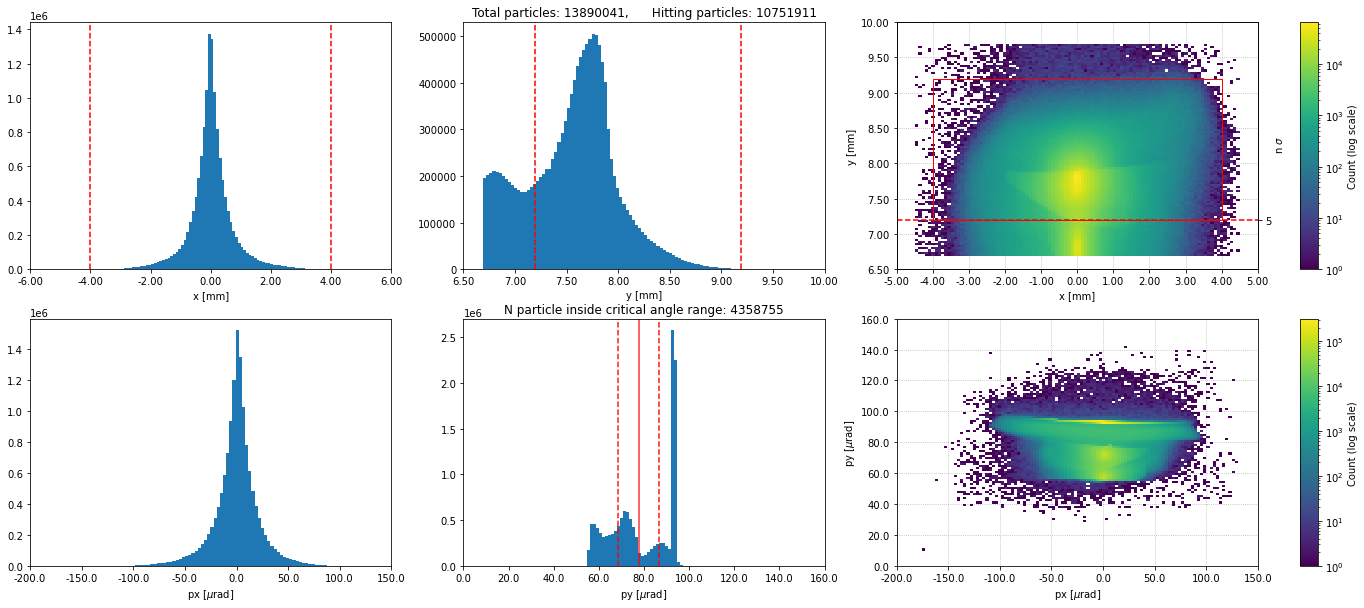

In [49]:
TCCP_blm_inj.compute_impact_particles(xpcrit=True)

In [50]:
BLM_blm_inj.load_particles(blm_inj, df_key = 'BLM_impacts')

!!! Succesful Jobs:  97 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_BLMs_inj___20240416-0937


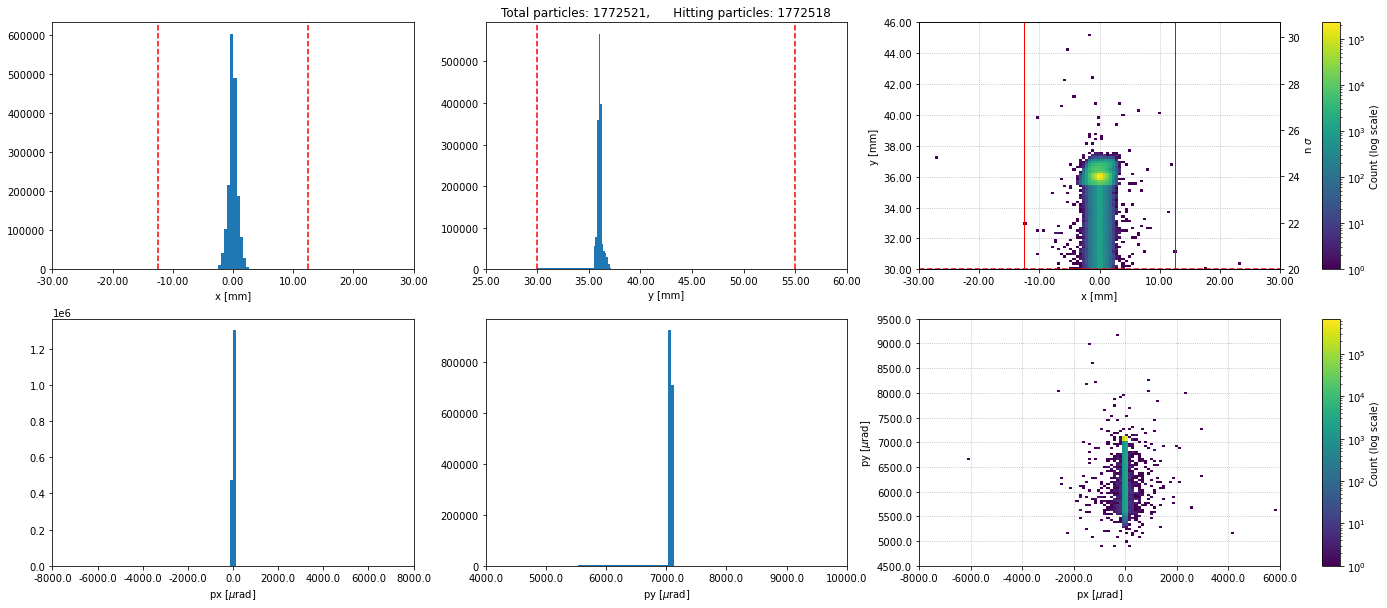

In [51]:
BLM_blm_inj.compute_impact_particles(log=False)

In [52]:
TCCP_blm_inj.compute_channeled_part(BLM_blm_inj.impact_part)

n particles that hit TCCP inside critical angle range: 	 1772120
n part inside critical angle range: 			 4358755 		40.66%
n part that hit TCCS (multiple):			 10751911 	16.48%
n part that hit TCCP: 					 1772518 		99.98%
total n particle in simulation: 			 9.7e+06	18.27%


## 1 TeV

In [53]:
TCCP_blm1.load_particles(blm1, df_key = 'TCCP_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_BLMs_1TeV___20240416-0934


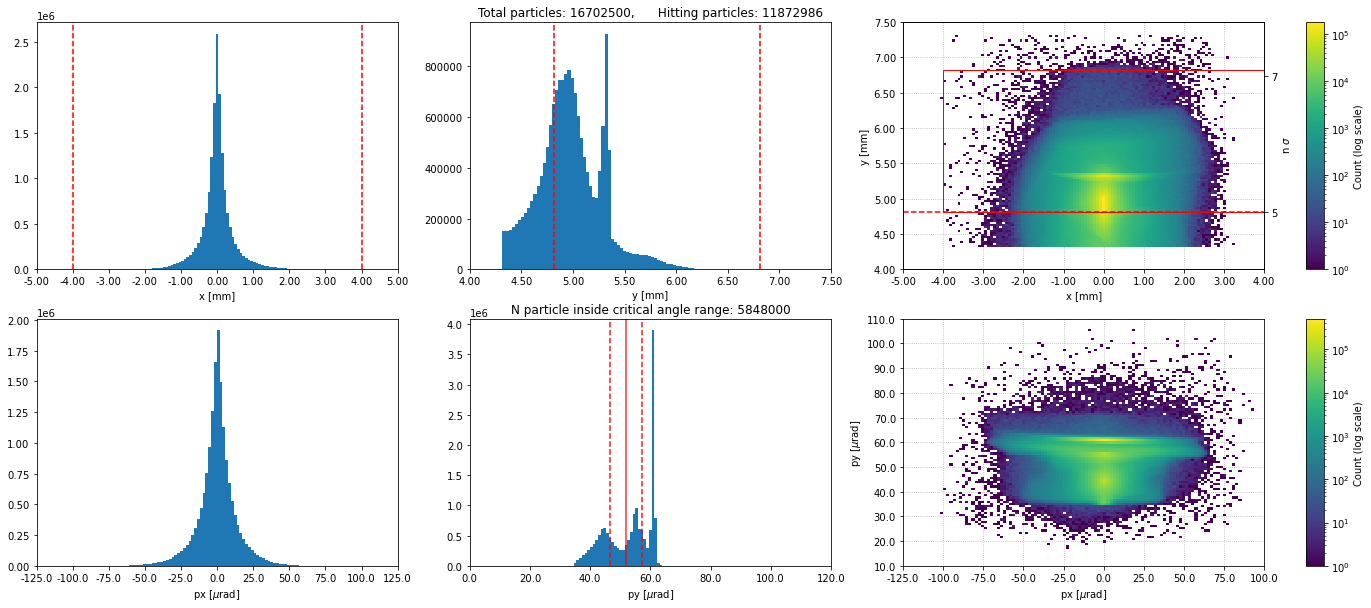

In [54]:
TCCP_blm1.compute_impact_particles(xpcrit=True)

In [55]:
BLM_blm1.load_particles(blm1, df_key = 'BLM_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_BLMs_1TeV___20240416-0934


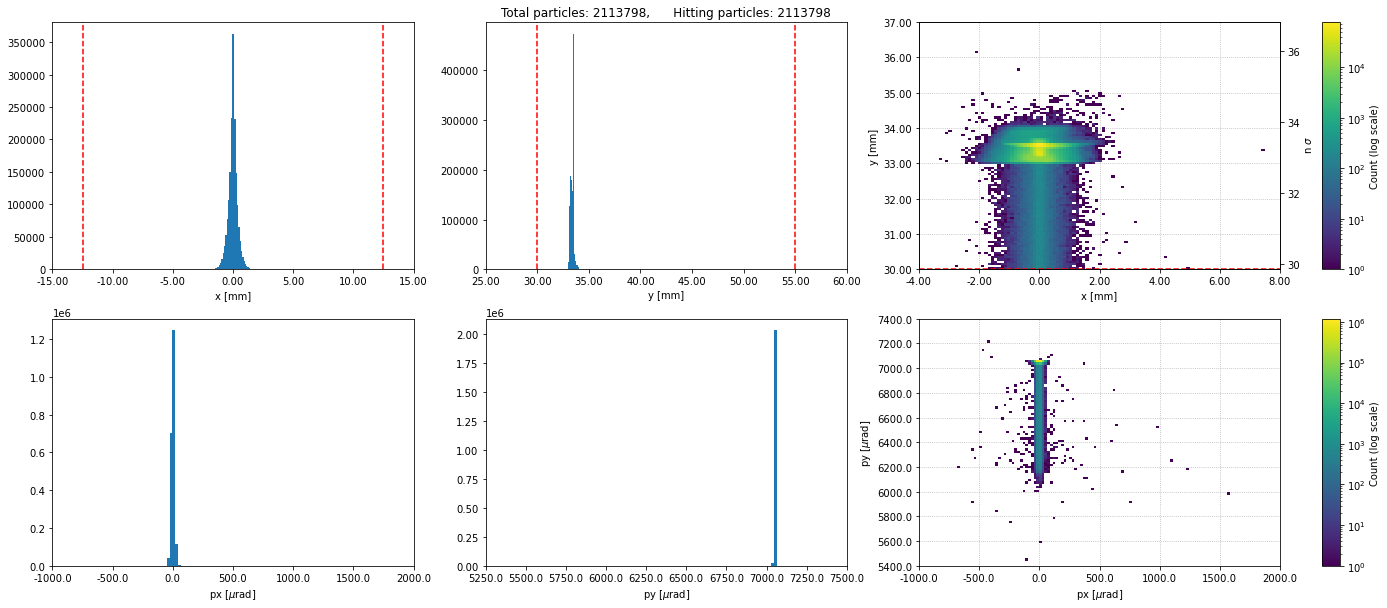

In [56]:
BLM_blm1.compute_impact_particles(log=False)

In [57]:
TCCP_blm1.compute_channeled_part(BLM_blm1.impact_part)

n particles that hit TCCP inside critical angle range: 	 2113515
n part inside critical angle range: 			 5848000 		36.14%
n part that hit TCCS (multiple):			 11872986 	17.80%
n part that hit TCCP: 					 2113798 		99.99%
total n particle in simulation: 			 9.9e+06	21.35%


## 3 TeV

In [58]:
TCCP_blm3.load_particles(blm3, df_key = 'TCCP_impacts')

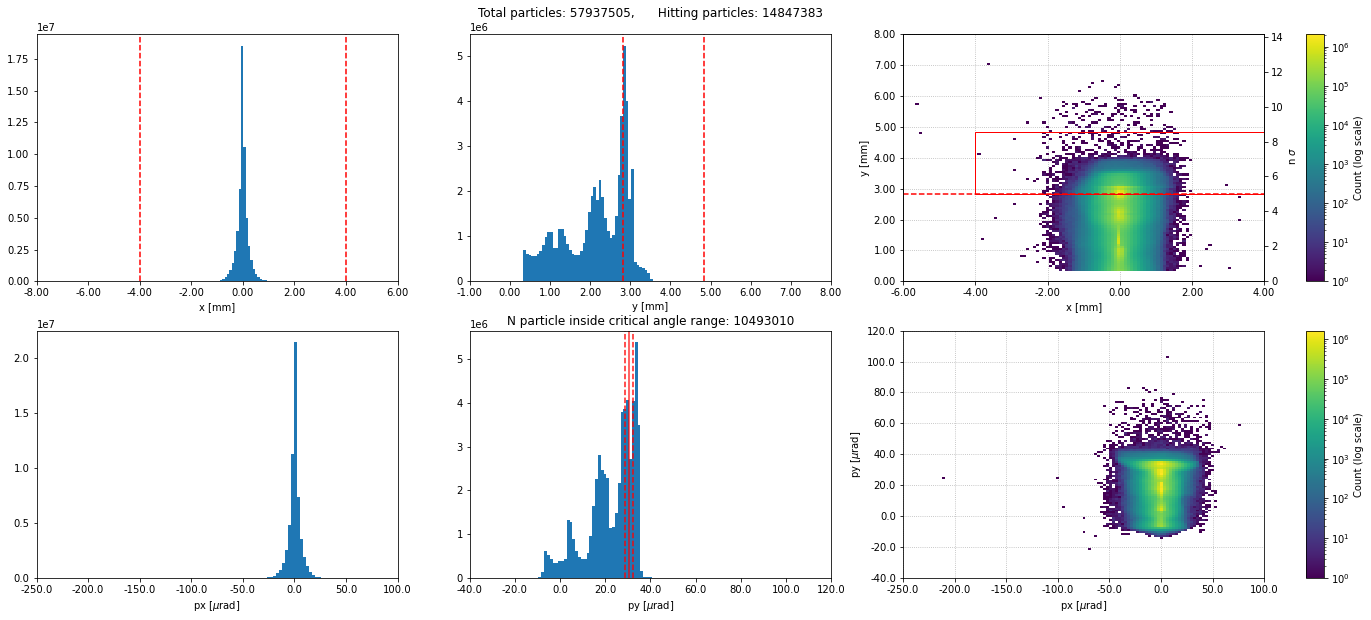

In [59]:
TCCP_blm3.compute_impact_particles(xpcrit=True)

In [60]:
BLM_blm3.load_particles(blm3, df_key = 'BLM_impacts')

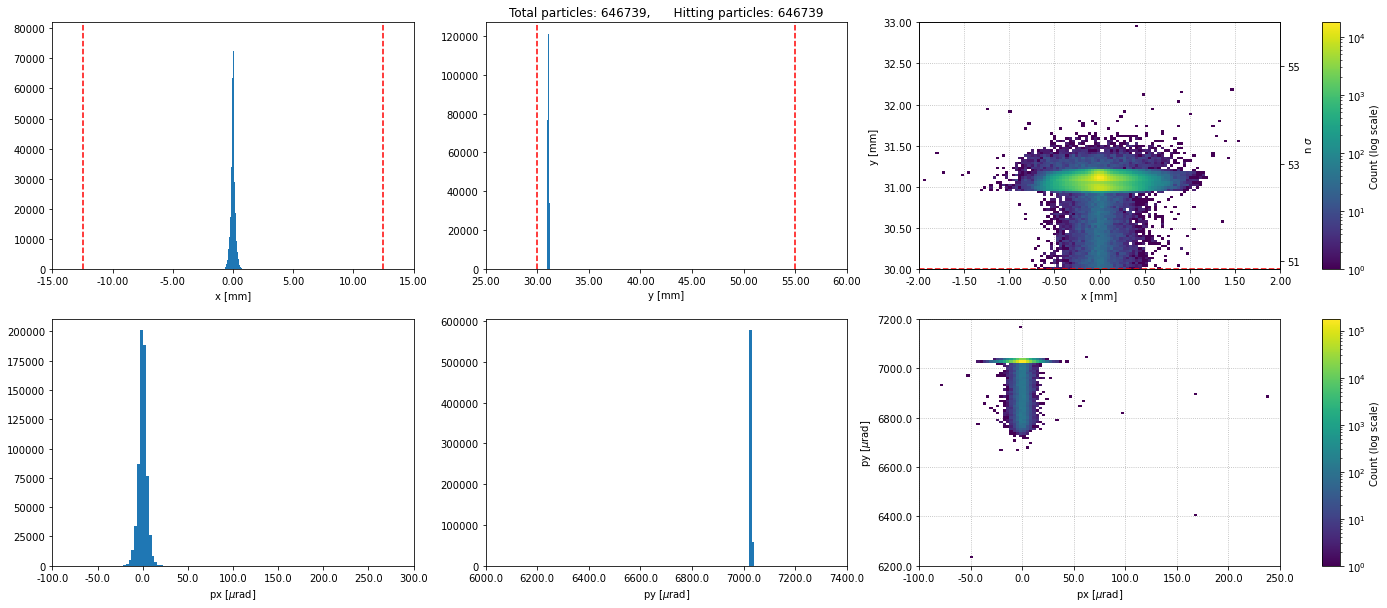

In [61]:
BLM_blm3.compute_impact_particles(log=False)

In [62]:
TCCP_blm3.compute_channeled_part(BLM_blm3.impact_part)

n particles that hit TCCP inside critical angle range: 	 646733
n part inside critical angle range: 			 10493010 		6.16%
n part that hit TCCS (multiple):			 14847383 	4.36%
n part that hit TCCP: 					 646739 		100.00%
total n particle in simulation: 			 1.0e+07	6.47%
